In [1]:
import sys; sys.path.insert(0, "..")
from multifunbrain import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, fcluster

In [2]:
path_root = Path.cwd().parent
path_data = path_root / Path("data")
path_atlas = Path('C:\\Users\\margh\\OneDrive - Politecnico di Milano\\Desktop\\multifun-brain\\atlas_timecourses')
os.chdir(path_root)
print(os.getcwd())

# Temporal resolution 
fs = 1/0.98

# Define frequency bands
slow5_min = 0.01
slow5_max = 0.027
slow4_min = 0.027
slow4_max = 0.073

c:\Users\margh\OneDrive - Politecnico di Milano\Desktop\multifun-brain


Found 13 subjects
Data shape: (488, 48) (488 timepoints, 48 ROIs)


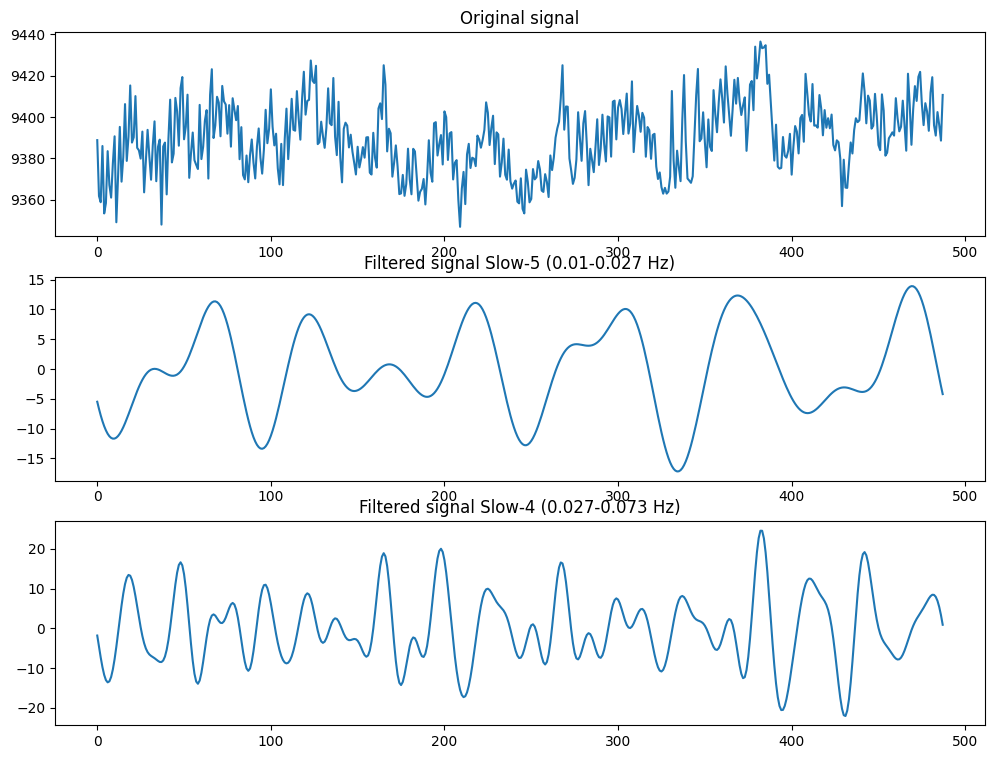

In [3]:
subject_folders = [f for f in path_atlas.iterdir() if f.is_dir() and f.name.startswith("sub-")]
print(f"Found {len(subject_folders)} subjects")

slow5_powers = []
slow4_powers = []

if len(subject_folders) > 0:
    bold_file = subject_folders[0] / "HarvardOxford_48Parcels_kwoptcomMIRDenoised_bold.ts.1D"
    
    if bold_file.exists():
        ts_original = np.loadtxt(bold_file)
        num_timepoints, num_rois = ts_original.shape
        print(f"Data shape: {ts_original.shape} ({num_timepoints} timepoints, {num_rois} ROIs)")
        
        ts_slow5 = np.zeros_like(ts_original)
        ts_slow4 = np.zeros_like(ts_original)
        
        for roi in range(num_rois):
            signal = ts_original[:, roi]
            
            # FFT
            n = len(signal)
            fft = np.fft.fft(signal)
            frequencies = np.fft.fftfreq(n, 1/fs)
            
            # Slow-5
            fft_slow5 = fft.copy()
            for i in range(len(frequencies)):
                freq = abs(frequencies[i])
                if freq < slow5_min or freq > slow5_max:
                    fft_slow5[i] = 0
            ts_slow5[:, roi] = np.real(np.fft.ifft(fft_slow5))
            
            # Slow-4
            fft_slow4 = fft.copy()
            for i in range(len(frequencies)):
                freq = abs(frequencies[i])
                if freq < slow4_min or freq > slow4_max:
                    fft_slow4[i] = 0
            ts_slow4[:, roi] = np.real(np.fft.ifft(fft_slow4))
            
            # Power
            power_slow5 = np.var(ts_slow5[:, roi])
            power_slow4 = np.var(ts_slow4[:, roi])
            
            slow5_powers.append(power_slow5)
            slow4_powers.append(power_slow4)
        
        plt.figure(figsize=(12, 9))
        
        plt.subplot(3, 1, 1)
        plt.plot(ts_original[:, 0])
        plt.title('Original signal')
        
        plt.subplot(3, 1, 2)
        plt.plot(ts_slow5[:, 0])
        plt.title(f'Filtered signal Slow-5 ({slow5_min}-{slow5_max} Hz)')
        
        plt.subplot(3, 1, 3)
        plt.plot(ts_slow4[:, 0])
        plt.title(f'Filtered signal Slow-4 ({slow4_min}-{slow4_max} Hz)')
        
        mean_slow5 = np.mean(slow5_powers)
        mean_slow4 = np.mean(slow4_powers)
    

Removed nodes in Slow-5: [17, 47, 15]


c:\Users\margh\OneDrive - Politecnico di Milano\Desktop\multifun-brain\notebooks\..\multifunbrain\lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
c:\Users\margh\OneDrive - Politecnico di Milano\Desktop\multifun-brain\notebooks\..\multifunbrain\lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


Text(0.5, 1.0, 'Cluster Transitions for Slow-5')

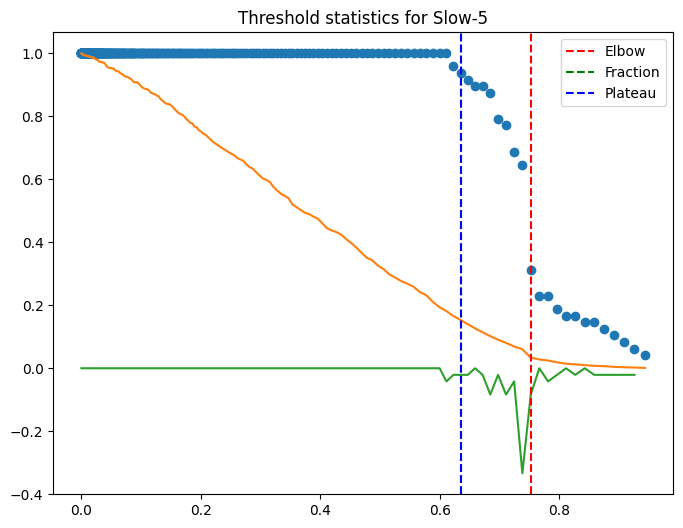

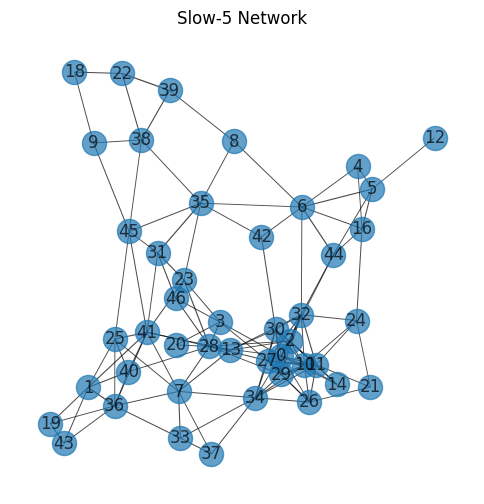

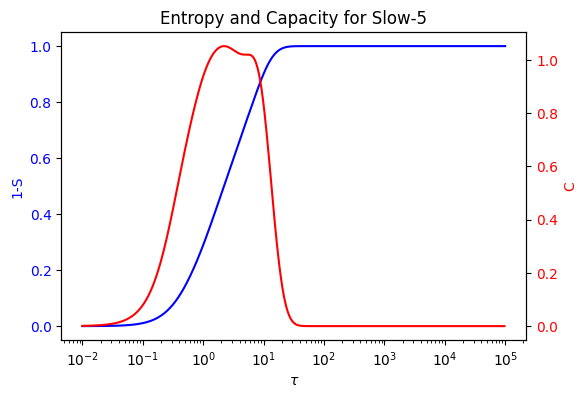

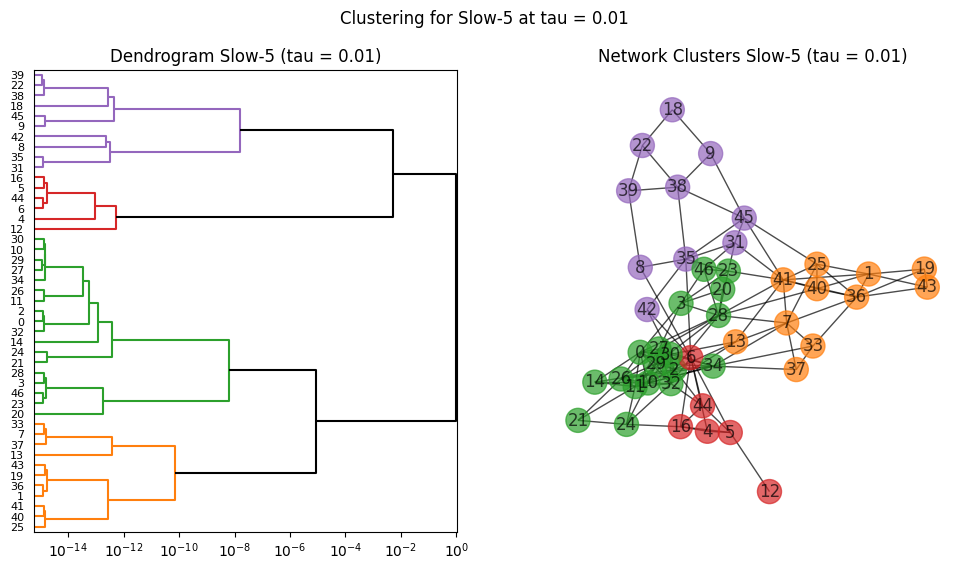

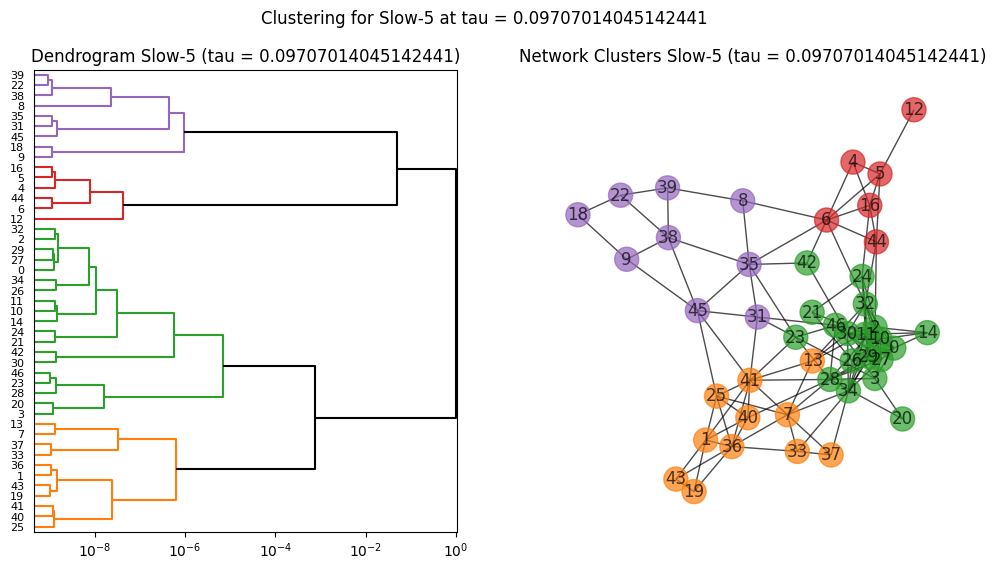

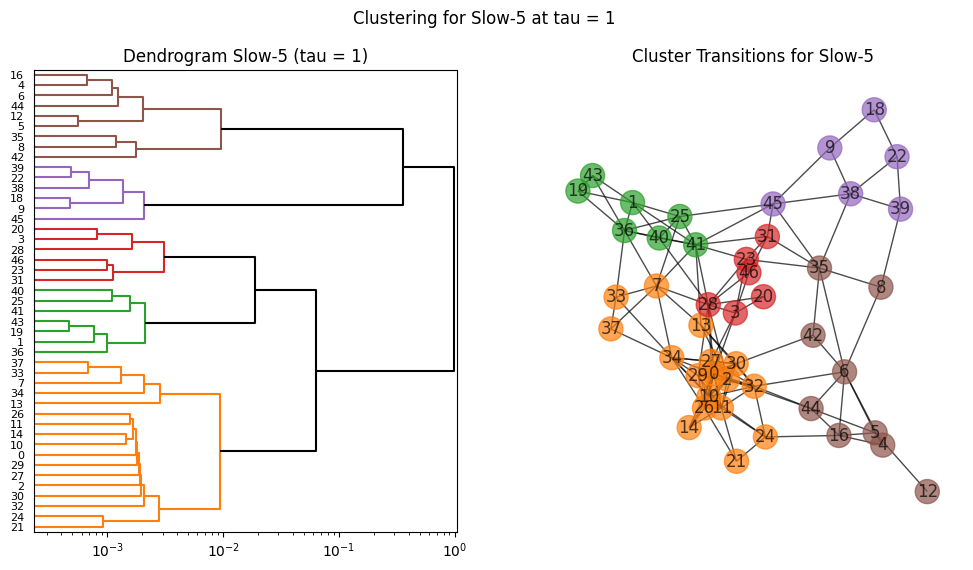

In [ ]:
G_slow5, remnodes_slow5 = build_correlation_network(ts_slow5.T)

Th_slow5, Einf_slow5, Pinf_slow5 = compute_threshold_stats(G_slow5)

Th1_slow5 = select_threshold_elbow(Th_slow5, Pinf_slow5)
Th2_slow5 = select_threshold_fraction(Th_slow5, Pinf_slow5)
Th3_slow5 = select_threshold_plateau(Th_slow5, Pinf_slow5, tol=0.07)

plt.figure(figsize=(8, 6))
plt.plot(Th_slow5, Pinf_slow5, 'o')
plt.plot(Th_slow5, Einf_slow5)
plt.plot(Th_slow5[:-1], np.diff(Pinf_slow5))
plt.axvline(x=Th1_slow5, color='r', linestyle='--', label='Elbow')
plt.axvline(x=Th2_slow5, color='g', linestyle='--', label='Fraction')
plt.axvline(x=Th3_slow5, color='b', linestyle='--', label='Plateau')
plt.legend()
plt.title('Threshold statistics for Slow-5')

G_slow5_thresh, remnodes_slow5_thresh = build_correlation_network(ts_slow5.T, threshold=Th3_slow5)
print(f"Removed nodes in Slow-5: {remnodes_slow5_thresh}")

L_slow5 = nx.laplacian_matrix(G_slow5_thresh).todense()
spectrum_slow5 = nx.laplacian_spectrum(G_slow5_thresh)

fig_slow5, ax_slow5 = plt.subplots(figsize=(6, 6))
weights_slow5 = [G_slow5_thresh[u][v]['weight'] for u, v in G_slow5_thresh.edges()]
nx.draw(G_slow5_thresh, with_labels=True, alpha=0.7, width=weights_slow5)
plt.title('Slow-5 Network')


rho_m_slow5 = lambda tau: rho_matrix(tau, L_slow5)
Sm1_slow5, Csp_slow5, VarL_slow5, t_slow5 = entropy(spectrum_slow5)

fig_ent_slow5, ax_ent_slow5 = plt.subplots(figsize=(6, 4))
plot_entropy_and_C(ax_ent_slow5, t_slow5, Sm1_slow5, Csp_slow5, color1="blue", color2="red")
plt.title('Entropy and Capacity for Slow-5')

# Partition analysis for Slow-5
partitions_slow5 = []
tau_values_slow5 = [1/100, 1/max(spectrum_slow5), 1]
thresholds_slow5 = [1e-7, 1e-4, 1e-2]

for i, tau in enumerate(tau_values_slow5):
    fig_part_slow5, ax_part_slow5 = plt.subplots(ncols=2, figsize=(12, 6))
    dists_slow5 = symmetrized_inverse_distance(tau, rho_m_slow5)
    linkage_matrix_slow5, label_list_slow5, tmax_slow5 = compute_normalized_linkage(dists_slow5, G_slow5_thresh, method='ward')
    
    threshold_slow5 = thresholds_slow5[i]
    tmin_slow5 = linkage_matrix_slow5[::, 2][0] - 0.5*linkage_matrix_slow5[::, 2][0]
    optimal_clusters_slow5 = fcluster(linkage_matrix_slow5, t=threshold_slow5, criterion='distance')
    partitions_slow5.append(optimal_clusters_slow5)
    
    dendro_slow5 = dendrogram(linkage_matrix_slow5, ax=ax_part_slow5[0],
                                color_threshold=threshold_slow5,
                                above_threshold_color='k',
                                orientation='right', labels=label_list_slow5)
    leaf_label_colors_slow5 = {label: color for label, color in zip(dendro_slow5['ivl'], dendro_slow5['leaves_color_list'])}
    node_colors_slow5 = [leaf_label_colors_slow5[label] for label in label_list_slow5]
    ax_part_slow5[0].set_xscale('log')
    ax_part_slow5[0].set_xlim(tmin_slow5)
    ax_part_slow5[0].set_title(f'Dendrogram Slow-5 (tau = {tau})')
    
    nx.draw(G_slow5_thresh, ax=ax_part_slow5[1], node_color=node_colors_slow5, with_labels=True, alpha=0.7)
    ax_part_slow5[1].set_title(f'Network Clusters Slow-5 (tau = {tau})')
    
    plt.suptitle(f'Clustering for Slow-5 at tau = {tau}')

# Plot sankey diagram
plot_sankey(partitions_slow5, tau_values_slow5)
partdict_tau = identify_switching_nodes(partitions_slow5, tau_values_slow5)

In [ ]:
G_slow4, remnodes_slow4 = build_correlation_network(ts_slow4.T)

Th_slow4, Einf_slow4, Pinf_slow4 = compute_threshold_stats(G_slow4)

Th1_slow4 = select_threshold_elbow(Th_slow4, Pinf_slow4)
Th2_slow4 = select_threshold_fraction(Th_slow4, Pinf_slow4)
Th3_slow4 = select_threshold_plateau(Th_slow4, Pinf_slow4, tol=0.07)

plt.figure(figsize=(8, 6))
plt.plot(Th_slow4, Pinf_slow4, 'o')
plt.plot(Th_slow4, Einf_slow4)
plt.plot(Th_slow4[:-1], np.diff(Pinf_slow4))
plt.axvline(x=Th1_slow4, color='r', linestyle='--', label='Elbow')
plt.axvline(x=Th2_slow4, color='g', linestyle='--', label='Fraction')
plt.axvline(x=Th3_slow4, color='b', linestyle='--', label='Plateau')
plt.legend()
plt.title('Threshold statistics for Slow-4')

G_slow4_thresh, remnodes_slow4_thresh = build_correlation_network(ts_slow4.T, threshold=Th3_slow4)
print(f"Removed nodes in Slow-4: {remnodes_slow4_thresh}")

L_slow4 = nx.laplacian_matrix(G_slow4_thresh).todense()
spectrum_slow4 = nx.laplacian_spectrum(G_slow4_thresh)

fig_slow4, ax_slow4 = plt.subplots(figsize=(6, 6))
weights_slow4 = [G_slow4_thresh[u][v]['weight'] for u, v in G_slow4_thresh.edges()]
nx.draw(G_slow4_thresh, with_labels=True, alpha=0.7, width=weights_slow4)
plt.title('Slow-4 Network')


rho_m_slow4 = lambda tau: rho_matrix(tau, L_slow4)
Sm1_slow4, Csp_slow4, VarL_slow4, t_slow4 = entropy(spectrum_slow4)

fig_ent_slow4, ax_ent_slow4 = plt.subplots(figsize=(6, 4))
plot_entropy_and_C(ax_ent_slow4, t_slow4, Sm1_slow4, Csp_slow4, color1="blue", color2="red")
plt.title('Entropy and Capacity for Slow-4')

# Partition analysis for Slow-4
partitions_slow4 = []
tau_values_slow4 = [1/100, 1/max(spectrum_slow4), 1]
thresholds_slow4 = [1e-7, 1e-4, 1e-2]

for i, tau in enumerate(tau_values_slow4):
    fig_part_slow4, ax_part_slow4 = plt.subplots(ncols=2, figsize=(12, 6))
    dists_slow4 = symmetrized_inverse_distance(tau, rho_m_slow4)
    linkage_matrix_slow4, label_list_slow4, tmax_slow4 = compute_normalized_linkage(dists_slow4, G_slow4_thresh, method='ward')
    
    threshold_slow4 = thresholds_slow4[i]
    tmin_slow4 = linkage_matrix_slow4[::, 2][0] - 0.5*linkage_matrix_slow4[::, 2][0]
    optimal_clusters_slow4 = fcluster(linkage_matrix_slow4, t=threshold_slow4, criterion='distance')
    partitions_slow4.append(optimal_clusters_slow4)
    
    dendro_slow4 = dendrogram(linkage_matrix_slow4, ax=ax_part_slow4[0],
                                color_threshold=threshold_slow4,
                                above_threshold_color='k',
                                orientation='right', labels=label_list_slow4)
    leaf_label_colors_slow4 = {label: color for label, color in zip(dendro_slow4['ivl'], dendro_slow4['leaves_color_list'])}
    node_colors_slow4 = [leaf_label_colors_slow4[label] for label in label_list_slow4]
    ax_part_slow4[0].set_xscale('log')
    ax_part_slow4[0].set_xlim(tmin_slow4)
    ax_part_slow4[0].set_title(f'Dendrogram Slow-4 (tau = {tau})')
    
    nx.draw(G_slow4_thresh, ax=ax_part_slow4[1], node_color=node_colors_slow4, with_labels=True, alpha=0.7)
    ax_part_slow4[1].set_title(f'Network Clusters Slow-4 (tau = {tau})')
    
    plt.suptitle(f'Clustering for Slow-4 at tau = {tau}')

# Plot sankey diagram
plot_sankey(partitions_slow4, tau_values_slow4)
partdict_tau = identify_switching_nodes(partitions_slow4, tau_values_slow4)